In [1]:
!pip install igraph
!pip install opencv-python

# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
![graphcut.png](attachment:graphcut.png)

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

# Problem

The problem at hand corresponds to performing binary segmentation of a given image accurately, i.e, separating the components (pixels) of the image into foreground and background based on various features such as colour intensities, labels of neighbouring pixels etc. This is achieved by minimal user interaction, as initially the user draws a rectangle on the image which indicates that everything lying outside the box corresponds to background and everything inside is unknown. Further, a few brushstrokes are added which correspond to the foreground, to assist the segmentation algorithm.

Grabcut algorithm is employed to perform the binary segmentation.

In [2]:
from math import sqrt
import numpy as np
import cv2
import igraph
import matplotlib.pyplot as plt
from sklearn import mixture
import random
from random import choice
from tqdm import tqdm
from time import time
import os
import json
import pandas as pd

In [3]:
FOREGROUND = 1
BACKGROUND = 0
UNKNOWN = -1
INF = 10 ** 3

In [4]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [5]:
def construct_trimap(img):
    h, w = img.shape[:2]
    labels, blue_pixels = np.zeros((h, w)), []
    for i in range(h):
        for j in range(w):
            # Finding borders of rectangle
            if img[i, j].tolist() == [255, 0, 0]:
                blue_pixels.append((i, j))
            # White brushstroke - foreground
            if img[i, j].tolist() == [255, 255, 255]:
                labels[i, j] = FOREGROUND
    # Pixels outside blue rectangle
    blue_pixels = sorted(blue_pixels)
    r1, c1 = blue_pixels[0]
    r2, c2 = blue_pixels[-1]
    for i in range(r1, r2):
        for j in range(c1, c2):
            if labels[i, j] != FOREGROUND:
                labels[i, j] = UNKNOWN
    return labels     

In [6]:
def create_graph(edges, weights, h, w):
    graph = igraph.Graph()
    graph.add_vertices((h * w) + 2)
    graph.add_edges(np.asarray(edges))
    graph.es['weight'] = np.asarray(weights)
    return graph

In [7]:
def get_dist(a1, b1):
    a = np.asarray(a1).astype(np.float32)
    b = np.asarray(b1).astype(np.float32)
    return ((a - b) ** 2).sum()

def compute_beta(img, nbrs=4, param='auto'):
    h, w = img.shape[:2]
    c, _sum = 0, 0
    intensities_diff = []
    
    diff_x = [1, 0, -1, 1]
    diff_y = [0, 1, 1, 1]
    
    for t in range(nbrs // 2):
        for i in range(h):
            for j in range(w):
                i1, j1, i2, j2 = i, j, i + diff_y[t], j + diff_x[t]
                if i1 < 0 or i1 >= h or i2 < 0 or i2 >= h or \
                    j1 < 0 or j1 >= w or j2 < 0 or j2 >= w:
                    continue
                intensity_diff = get_dist(img[i1, j1], img[i2, j2])
                intensities_diff.append(intensity_diff)
    
    if param == 'auto':
        return 1 / (2 * (sum(intensities_diff) / len(intensities_diff)))
    return 1 / (2 * intensities_diff[int(param * len(intensities_diff))])
                    
def get_pairwise_potentials_graph(img, labels, nbrs=4, beta='auto', gamma=50):
    h, w = img.shape[:2]
    edges, weights, largest_wt = [], [], -1

    if beta == 'auto':
        beta_val = compute_beta(img, nbrs)
    else:
        beta_val = compute_beta(img, nbrs, beta)
    
    diff_x = [1, 0, -1, 1]
    diff_y = [0, 1, 1, 1]
    
    for t in range(nbrs // 2):
        for i in range(h):
            for j in range(w):
                i1, j1, i2, j2 = i, j, i + diff_y[t], j + diff_x[t]
                if i1 < 0 or i1 >= h or i2 < 0 or i2 >= h or \
                    j1 < 0 or j1 >= w or j2 < 0 or j2 >= w:
                    continue
                node_1 = (i1 * w) + j1 + 1
                node_2 = (i2 * w) + j2 + 1
                edges.append([node_1, node_2])
                dis = sqrt(get_dist([i1, j1], [i2, j2]))
                intensity_diff = get_dist(img[i1, j1], img[i2, j2])
                wt = (gamma / dis) * np.exp(-beta_val * intensity_diff)
                weights.append(wt)
    return edges, weights

# Grabcut Algorithm, Procedure

* Initially, the user draws a blue rectangular box on the image, which signifies the region of the image we should look for, to extract the foreground; and hence everything outside this box is treated as background. Additionally, the user also adds few brushstrokes indicating pixels of foreground (inside the box). These act as seed pixels whose label is fixed, while the labels of other pixels are still unknown (the ones inside box are tentatively initialized as foreground pixels, this estimate is refined after further iterations).

* 2 Gaussian Mixture Models (GMMs) are initialized - where one corresponds to foreground and the other corresponds to background. Both are initialized to have 5 components by default. These models are later used in predicting labels of pixels by clustering them based on intensities and current labels distribution, such that pixels with similar intensities have similar labels.

* Based on the parameter "number of neighbours", a graph is constructed such that a node is indicated by an individual pixel, and the edges are indicated by neighbouring pixels and weighted by their connectivity. Initially, all edges between neighbouring pixels are computed (these edge weights explain the affinity of neighbouring pixels having same labels). For a particular pair of such pixels considered, the edge between them has a finite weight positively correlated with the similarity of their colour intensities and negatively correlated with the distance between them. For the unary potentials part (individual likelihood of a pixel belonging to a label), two additional nodes - source and sink are added, such that source is connected to the foreground pixels and sink is connected to the background pixels. Above 2 GMMs are used to compute unary potentials for each pixel, based on their mean likelihood of belonging to foreground / background.

* Based on the above constructed graph, where the edge weight between any two nodes indicates connectivity, a mincut is performed, such that dissimilar pixels are partitioned into different segments, and similar segments are grouped as one. This partition is used to assign labels to every pixel - as foreground or background. Further, these labels are utilized in learning the parameters of the GMM (in the next iteration) and predicting labels accordingly for the next step.

* The above process is repeated iteratively, for the required number of iterations passed as a parameter. Eventually, the segmented image is displayed such that the background is completely masked.

In [8]:
def grabcut(img, true_labels, iterations=3, nbrs=4, beta='auto', n_components=5, gamma=50, is_bayesian=False):
    st_tim = time()
    # Initialize background and foreground based on UI, 2 GMMs / Bayesian Gaussian Mixture models with 5 components each
    labels = np.copy(true_labels)
    h, w = labels.shape[:2]
    SOURCE, SINK = 0, (h * w) + 1
    for i in range(h):
        for j in range(w):
            if labels[i, j] == UNKNOWN:
                labels[i, j] = FOREGROUND
    if not is_bayesian:
        model_fg, model_bg = mixture.GaussianMixture(n_components=n_components), mixture.GaussianMixture(n_components=n_components)
    else:
        model_fg, model_bg = mixture.BayesianGaussianMixture(n_components=n_components), mixture.BayesianGaussianMixture(n_components=n_components)
        
    # Pairwise potentials
    p_edges, p_weights = get_pairwise_potentials_graph(img, labels, nbrs=4, beta='auto', gamma=50)
    
    for t in range(iterations):
        edges = p_edges.copy()
        weights = p_weights.copy()
        
        # Based on current labels of fg and bg, learn GMM / Bayesian model parameters accordingly
        model_fg.fit([img[i, j] for i in range(h) for j in range(w) if labels[i, j] == FOREGROUND])
        model_bg.fit([img[i, j] for i in range(h) for j in range(w) if labels[i, j] == BACKGROUND])

        # Unary potentials - connect fg pixels to source and bg pixels to sink
        for i in range(h):
            for j in range(w):
                node = (i * w) + j + 1
                edges += [[SOURCE, node], [node, SINK]]
                if true_labels[i, j] == UNKNOWN:
                    weights += [-model_bg.score([img[i, j]]), -model_fg.score([img[i, j]])]
                elif true_labels[i, j] == FOREGROUND:
                    weights += [INF, 0]
                else:
                    weights += [0, INF]
        
        # Construct graph
        graph = create_graph(edges, weights, h, w)
        
        # Mincut
        cut = graph.mincut(SOURCE, SINK, capacity='weight')
        print(f"Iteration-{t+1}, Mincut value = {cut.value}")
        
        # Fg and bg pixels re-assignment
        fg_idx, bg_idx = list(cut[0]), list(cut[1])
        for idx in fg_idx:
            if idx == SOURCE or idx == SINK:
                continue
            node = idx - 1
            j = node % w
            i = (node - j) // w
            labels[i, j] = FOREGROUND
        for idx in bg_idx:
            if idx == SOURCE or idx == SINK:
                continue
            node = idx - 1
            j = node % w
            i = (node - j) // w
            labels[i, j] = BACKGROUND
    
    end_tim = time()
    print(f"Time taken overall = {end_tim - st_tim} secs")
    return labels

In [9]:
def get_accuracy(img_gt, mask_pred):
    h, w = img_gt.shape[:2]
    matches = 0
    for i in range(h):
        for j in range(w):
            if (img_gt[i, j].tolist() == [0, 0, 0] and mask_pred[i, j] == BACKGROUND) or \
                (img_gt[i, j].tolist() == [255, 255, 255] and mask_pred[i, j] == FOREGROUND):
                matches += 1
    acc = matches / (h * w)
    return acc

def get_jacc_sim(img_gt, mask_pred):
    h, w = img_gt.shape[:2]
    int_size_f, un_size_f = 0, 0
    for i in range(h):
        for j in range(w):
            if img_gt[i, j].tolist() == [255, 255, 255] and mask_pred[i, j] == FOREGROUND:
                int_size_f += 1
            if img_gt[i, j].tolist() == [255, 255, 255] or mask_pred[i, j] == FOREGROUND:
                un_size_f += 1
    jacc_fg = int_size_f / un_size_f
    return jacc_fg

def get_dice_sim(img_gt, mask_pred):
    h, w = img_gt.shape[:2]
    overlap_f, denom = 0, 0
    for i in range(h):
        for j in range(w):
            if img_gt[i, j].tolist() == [255, 255, 255] and mask_pred[i, j] == FOREGROUND:
                overlap_f += 1
            if img_gt[i, j].tolist() == [255, 255, 255]:
                denom += 1
            if mask_pred[i, j] == FOREGROUND:
                denom += 1
    dice_fg = (2 * overlap_f) / denom
    return dice_fg

In [10]:
with open('../results/manual_marking.json', 'r') as _f:
    init_labels = json.load(_f)

In [17]:
def get_grabcut_metrics_and_output(filename, gt_filename, iterations=3, nbrs=4, beta='auto', n_components=5, gamma=50, is_bayesian=False):
    img = cv2.imread(filename)
    img_gt = cv2.imread(gt_filename)
    img2 = img.copy() 
    true_labels = np.asarray(init_labels[filename.split('/')[-1]])
    mask = grabcut(img, true_labels, iterations, nbrs, beta, n_components, gamma, is_bayesian)
    metrics = [get_accuracy(img_gt, mask), get_jacc_sim(img_gt, mask), get_dice_sim(img_gt, mask)]
    mask2 = np.where((mask == 1), 255, 0).astype('uint8')
    output = cv2.bitwise_and(img2, img2, mask = mask2)
    return metrics, output

In [12]:
def run(filename, gt_filename, iterations=3, nbrs=4, beta='auto', n_components=5, gamma=50):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }
    
    img = cv2.imread(filename)
    img_gt = cv2.imread(gt_filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown
    metrics = [0.5, 0.5, 0.5]

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
                    
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG            
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            true_labels = construct_trimap(img)
            mask = grabcut(img, true_labels, iterations, nbrs, beta, n_components, gamma)
            metrics = [get_accuracy(img_gt, mask), get_jacc_sim(img_gt, mask), get_dice_sim(img_gt, mask)]
            EventObj.flags = FLAGS
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)

In [13]:
# Execute below line to check how 'run' functions - UI (default params can be changed)
run('../images/teddy.jpg', '../ground_truth/teddy.bmp')

In [15]:
# Code for storing manually marked pixels for all 30 images 

# all_images = sorted([f for f in os.listdir('../images') if os.path.isfile(os.path.join('../images', f))])
# ground_truths = sorted([f for f in os.listdir('../ground_truth') if os.path.isfile(os.path.join('../ground_truth', f))])
# man_data = {}
# for i in range(len(all_images[:])):
#     f, gt_f = all_images[i], ground_truths[i]
#     init_labels = run('../images/' + f, '../ground_truth/' + gt_f, iterations=3)
#     man_data[f] = init_labels.tolist()
#     cv2.destroyAllWindows()

# import json
# with open('../results/manual_marking.json', 'w') as _f:
#     json.dump(man_data, _f)

In [37]:
all_images = sorted([f for f in os.listdir('../images') if os.path.isfile(os.path.join('../images', f))])
ground_truths = sorted([f for f in os.listdir('../ground_truth') if os.path.isfile(os.path.join('../ground_truth', f))])
metrics_data = []
for i in range(len(all_images[:])):
    f, gt_f = all_images[i], ground_truths[i]
    print(f)
    metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, iterations=3)
    print(metrics)
    print('-' * 120)
    metrics_data.append([f] + metrics)
df = pd.DataFrame(metrics_data, columns=['Title', 'Accuracy', 'Jaccard Similarity', 'Dice Similarity'])
df.to_csv('../results/metrics_results.csv')
df

banana1.jpg
613280
Time for iter unary potent calc = 79.48149490356445 s
Number of edges = 1227680
Iteration-1, Mincut value = 2501871.6970012696
613280
Time for iter unary potent calc = 77.94366383552551 s
Number of edges = 1227680
Iteration-2, Mincut value = 2411962.7279268675
613280
Time for iter unary potent calc = 79.20557045936584 s
Number of edges = 1227680
Iteration-3, Mincut value = 2409445.581042255
Time taken overall = 305.4514093399048 secs
------------------------------------------------------------------------------------------------------------------------
[0.6821354166666667, 0.4462327174566448, 0.6170966982981727]
------------------------------------------------------------------------------------------------------------------------
banana2.jpg
613280
Time for iter unary potent calc = 84.74890875816345 s
Number of edges = 1227680
Iteration-1, Mincut value = 3144604.5019362695
613280
Time for iter unary potent calc = 89.65476274490356 s
Number of edges = 1227680
Iterati

308608


/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


Time for iter unary potent calc = 14.927156925201416 s
Number of edges = 618008
Iteration-1, Mincut value = 123296.35248617326
308608


/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


Time for iter unary potent calc = 15.156596899032593 s
Number of edges = 618008
Iteration-2, Mincut value = 110382.60492438148
308608


/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


Time for iter unary potent calc = 14.774287462234497 s
Number of edges = 618008
Iteration-3, Mincut value = 110982.96084595945
Time taken overall = 71.62213468551636 secs
------------------------------------------------------------------------------------------------------------------------
[0.9707950872656755, 0.6736963744041601, 0.8050401311814965]
------------------------------------------------------------------------------------------------------------------------
grave.jpg
538950
Time for iter unary potent calc = 30.54890489578247 s
Number of edges = 1078950
Iteration-1, Mincut value = 847853.1715324473
538950
Time for iter unary potent calc = 29.446496963500977 s
Number of edges = 1078950
Iteration-2, Mincut value = 828229.8141163894
538950
Time for iter unary potent calc = 30.39638090133667 s
Number of edges = 1078950
Iteration-3, Mincut value = 826101.6124019155
Time taken overall = 138.98464798927307 secs
-----------------------------------------------------------------------

Time for iter unary potent calc = 26.97114062309265 s
Number of edges = 1078950
Iteration-2, Mincut value = 976752.6737694659
538950
Time for iter unary potent calc = 29.157655477523804 s
Number of edges = 1078950
Iteration-3, Mincut value = 982765.8455948192
Time taken overall = 135.0860471725464 secs
------------------------------------------------------------------------------------------------------------------------
[0.9973666666666666, 0.9623968690501375, 0.98083816197278]
------------------------------------------------------------------------------------------------------------------------
person8.jpg
613280
Time for iter unary potent calc = 80.64892745018005 s
Number of edges = 1227680
Iteration-1, Mincut value = 2827990.518022038
613280
Time for iter unary potent calc = 79.95791053771973 s
Number of edges = 1227680
Iteration-2, Mincut value = 2760168.917457755
613280
Time for iter unary potent calc = 78.39296388626099 s
Number of edges = 1227680
Iteration-3, Mincut value = 27

,Title,Accuracy,Jaccard Similarity,Dice Similarity
0,banana1.jpg,0.682135,0.446233,0.617097
1,banana2.jpg,0.992370,0.968308,0.983899
2,banana3.jpg,0.868815,0.641950,0.781936
3,book.jpg,0.914551,0.812034,0.896268
4,bool.jpg,0.450419,0.187508,0.315801
5,bush.jpg,0.850678,0.519389,0.683682
6,ceramic.jpg,0.752360,0.551243,0.710712
7,cross.jpg,0.777281,0.401896,0.573360
8,doll.jpg,0.705442,0.550902,0.710428
9,elefant.jpg,0.763327,0.575870,0.730860


In [15]:
df = pd.read_csv('../results/metrics_results.csv')
accuracies, jacc_sims, dice_sims = df['Accuracy'].tolist(), df['Jaccard Similarity'].tolist(), df['Dice Similarity'].tolist()
print(f'Average Accuracy = {sum(accuracies) / 30}')
print(f'Average Jaccard Similarity = {sum(jacc_sims) / 30}')
print(f'Average Dice Similarity = {sum(dice_sims) / 30}')

Average Accuracy = 0.8697996712247282
Average Jaccard Similarity = 0.6560581335741917
Average Dice Similarity = 0.766592565433061


## Note - 
It can be observed that the average values achieved for accuracy are higher than those achieved by other 2 metrics, as accuracy is a relatively basic metric which is highly prone to bias towards label prediction (where high values can be reached if the proportion of majority labels are higher). 

Iteration-1, Mincut value = 2151270.2859470174
Iteration-2, Mincut value = 2055613.070004298
Iteration-3, Mincut value = 2055726.772668488
Time taken overall = 271.0416932106018 secs
------------------------------------------------------------------------------------------------------------------------


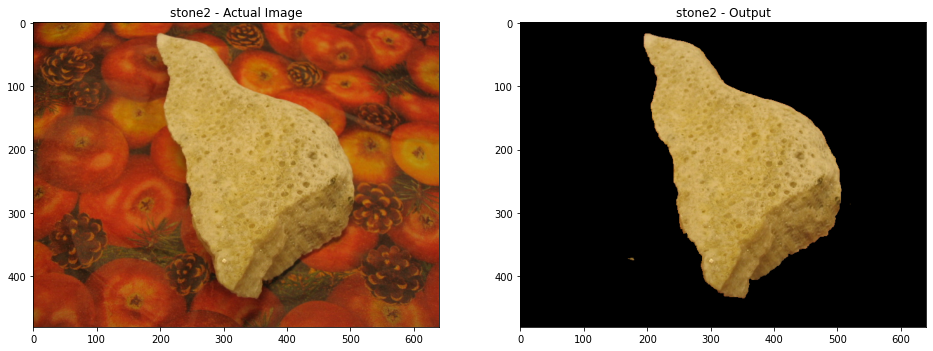

Iteration-1, Mincut value = 709727.5477187247
Iteration-2, Mincut value = 661178.095765699
Iteration-3, Mincut value = 644481.7135686307
Time taken overall = 109.88178944587708 secs
------------------------------------------------------------------------------------------------------------------------


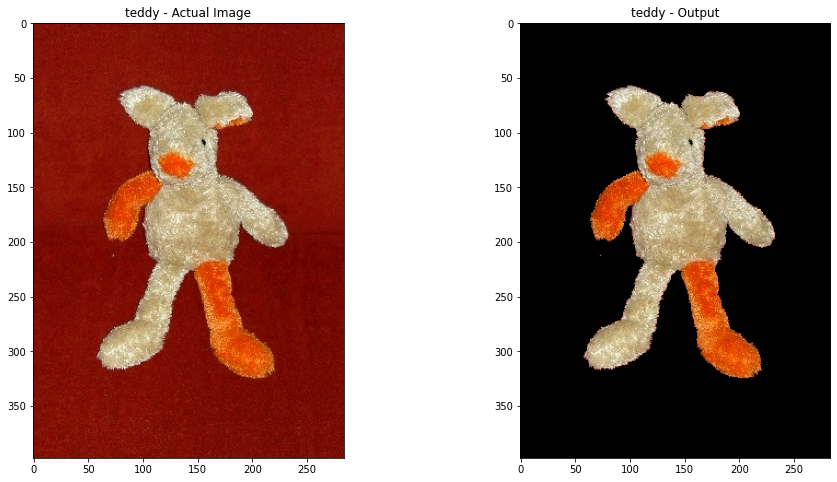

Iteration-1, Mincut value = 1028767.5809442917
Iteration-2, Mincut value = 976773.6202938715
Iteration-3, Mincut value = 974964.158600215
Time taken overall = 142.89548206329346 secs
------------------------------------------------------------------------------------------------------------------------


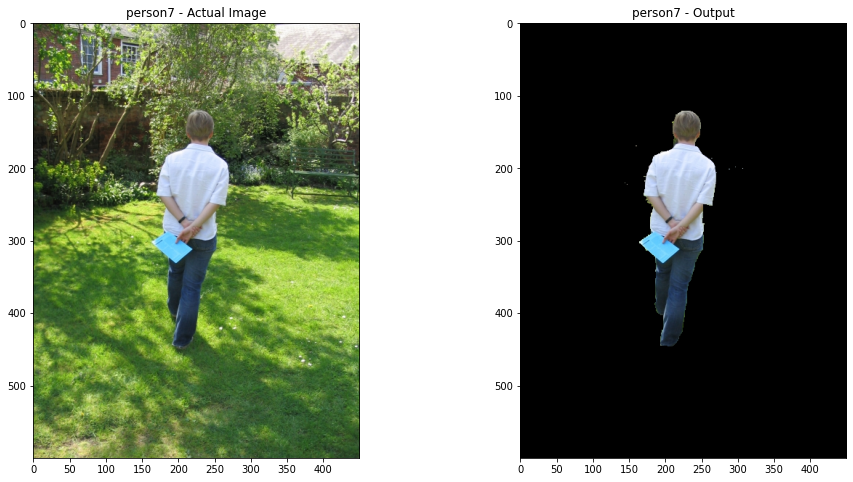

Iteration-1, Mincut value = 2238301.0139066135
Iteration-2, Mincut value = 2157409.84479821
Iteration-3, Mincut value = 2157090.6307742996
Time taken overall = 321.8761351108551 secs
------------------------------------------------------------------------------------------------------------------------


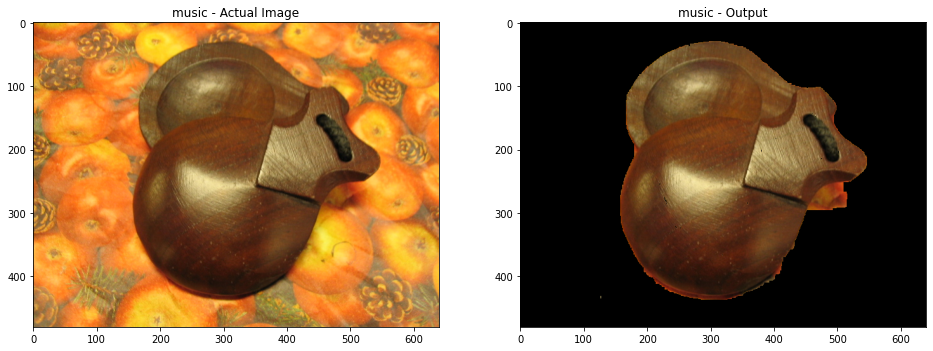

Iteration-1, Mincut value = 3142870.1350511485
Iteration-2, Mincut value = 3020078.796634059
Iteration-3, Mincut value = 3013436.872131482
Time taken overall = 345.64420318603516 secs
------------------------------------------------------------------------------------------------------------------------


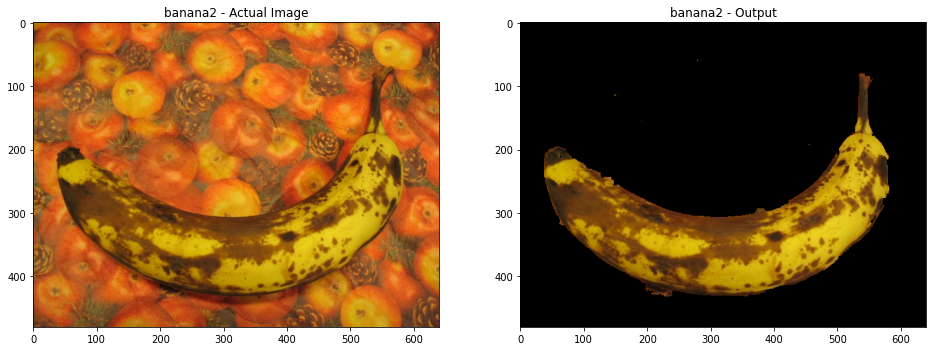

Iteration-1, Mincut value = 2223717.687254506
Iteration-2, Mincut value = 2200702.4436246706
Iteration-3, Mincut value = 1959765.906832684
Time taken overall = 295.4036681652069 secs
------------------------------------------------------------------------------------------------------------------------


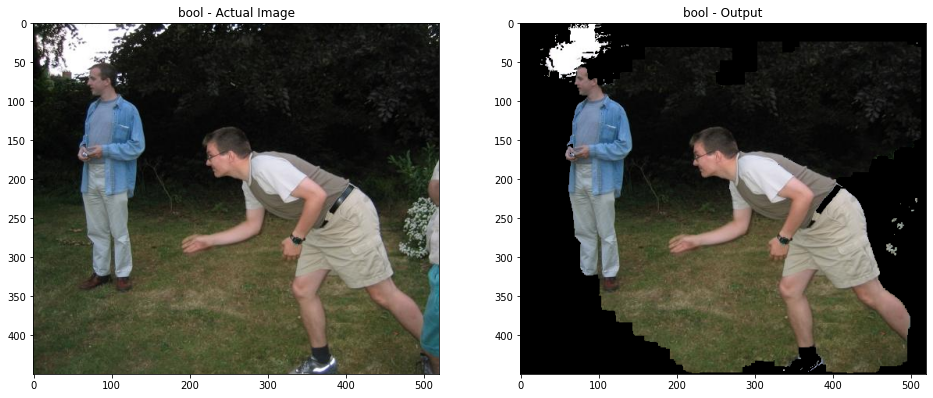

Iteration-1, Mincut value = 2502975.1164446096
Iteration-2, Mincut value = 2415745.7599748103
Iteration-3, Mincut value = 2404273.5967306816
Time taken overall = 348.33970308303833 secs
------------------------------------------------------------------------------------------------------------------------


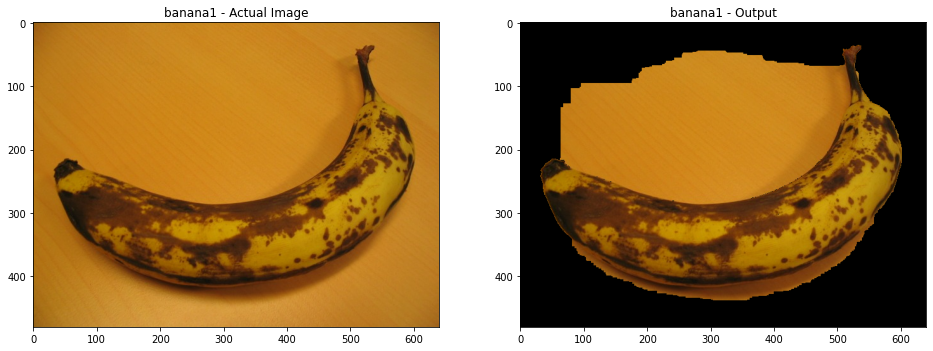

In [15]:
great_output = ['stone2', 'teddy', 'person7', 'music', 'banana2']
bad_output = ['bool', 'banana1']
# Names of images whose segmentation is visualized
seg_images = great_output + bad_output
for name in seg_images:
    metrics, output = get_grabcut_metrics_and_output('../images/' + f'{name}.jpg', '../ground_truth/' + f'{name}.bmp')
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    gt_img = cv2.imread('../images/' + f'{name}.jpg')
    plt.title(f'{name} - Actual Image')
    plt.imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title(f'{name} - Output')
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.savefig(f'../results/{name}-segmented.png')
    plt.show()

# Best and worst results

It can be observed that significantly good results have been obtained (in very few iterations alone) for some of the images, such as 'stone2', 'teddy', 'person7', 'music' and 'banana2'. All the 3 metrics values are higher in these cases. One of the primary reasons is the type of the image, where pixel intensities are very useful for determining their label (which is very distinctive in all the above images).

For a few of the images such as 'bool' and 'banana1', the distribution of pixel intensities isn't that obvious as in above cases, and hence requires more iterations (and thus more time) to yield better outputs. 

We can observe that the time taken for the computation of the cut is highly positively correlated with the resolution of the image, as in most cases (despite of good / bad performance), the time taken for relatively larger images (such as 'banana1') is significantly higher when compared with smaller images (such as 'teddy'). The time taken for all the cases above are logged accordingly.

In [14]:
_iterations = [2, 5, 8]
_mixture_components = [3, 10, 15]
_neighbours = [4, 8]
_gamma = [20, 50, 100]
_beta = ['auto', 0.2, 0.8]
is_bayesian = [False, True]
f, gt_f = 'banana3.jpg', 'banana3.bmp'
gt_img = cv2.imread('../ground_truth/' + gt_f)

### Note - 

An image with sub-par accuracy (on performing cut) has been chosen for the below analysis, such that any improvement / change in performance can be appreciated in a better manner.

In [21]:
def tune_parameters(_list, prop_name):
    plt.figure(figsize = (16, 8))
    for i in range(len(_list)):
        if prop_name != 'mixture':
            print(f'For {_list[i]} {prop_name}:')
        else:
            if i == 0:
                print('For GMM')
            else:
                print('For Bayesian Gaussian')
        
        if prop_name == 'iterations':
            metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, iterations=_list[i])
        elif prop_name == 'components':
            metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, n_components=_list[i])
        elif prop_name == 'neighbours':
            metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, nbrs=_list[i])
        elif prop_name == 'gamma':
            metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, gamma=_list[i])
        elif prop_name == 'mixture':
            metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, is_bayesian=_list[i])
        else:
            metrics, output = get_grabcut_metrics_and_output('../images/' + f, '../ground_truth/' + gt_f, beta=_list[i])
        
        plt.subplot(1, len(_list), i + 1)
        if prop_name != 'mixture':
            plt.title(f'{f} - {_list[i]} {prop_name}')
        else:
            if i == 0:
                plt.title(f'{f} - GMM')
            else:
                plt.title(f'{f} - Bayesian Gaussian Mixture')
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        print(f'Accuracy = {metrics[0]}, Jaccard sim = {metrics[1]}, Dice sim = {metrics[2]}')
        print('-' * 120)
        print()
    plt.savefig(f'../results/{f}_{prop_name}.png')
    plt.show()

For 2 iterations:
Iteration-1, Mincut value = 3282040.24501446
Iteration-2, Mincut value = 3235229.6019817246
Time taken overall = 377.14648151397705 secs
Accuracy = 0.7945377604166667, Jaccard sim = 0.5383715232320868, Dice sim = 0.6999239326804222
------------------------------------------------------------------------------------------------------------------------

For 5 iterations:
Iteration-1, Mincut value = 3281795.562818611
Iteration-2, Mincut value = 3235252.4690069556
Iteration-3, Mincut value = 3208684.5803366294
Iteration-4, Mincut value = 3192143.8011784405
Iteration-5, Mincut value = 3183408.4709057035
Time taken overall = 588.7616927623749 secs
Accuracy = 0.91630859375, Jaccard sim = 0.7355536812655572, Dice sim = 0.8476299975108751
------------------------------------------------------------------------------------------------------------------------

For 8 iterations:
Iteration-1, Mincut value = 3281792.7517992174
Iteration-2, Mincut value = 3235212.474476381
Iteration

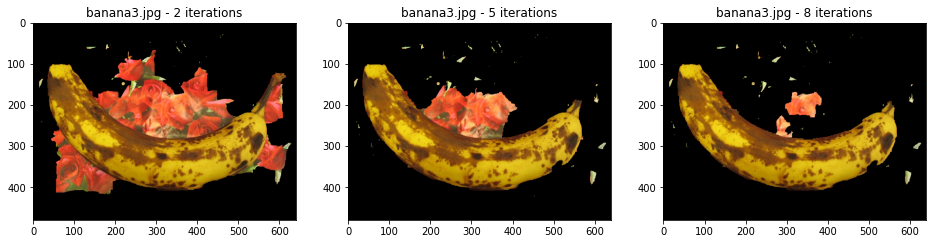

In [19]:
tune_parameters(_iterations, 'iterations')

## Inference

It can be inferred that increasing the number of iterations plays a very important role in improving the performance of the cut, as can be observed from the huge jump in accuracy metrics above, on comparing 2 iterations and 8 iterations. It can also be seen that the boost in performance from 2 to 5 iterations is much higher than from 5 to 8 iterations, indicating hints of convergence.

Although, the output quality improves at the cost of efficiency. An apt trade-off has to be achieved between both these parameters to obtain desirable outputs in reasonable time.

For 3 components:
Iteration-1, Mincut value = 3358942.099954059
Iteration-2, Mincut value = 3300525.1933769668
Iteration-3, Mincut value = 3234412.8971692645
Time taken overall = 302.00917863845825 secs
Accuracy = 0.911318359375, Jaccard sim = 0.7219676481094045, Dice sim = 0.8385379933264978
------------------------------------------------------------------------------------------------------------------------

For 10 components:
Iteration-1, Mincut value = 3245694.1988066705
Iteration-2, Mincut value = 3189632.9302187045
Iteration-3, Mincut value = 3182403.3758640536
Time taken overall = 470.0121247768402 secs
Accuracy = 0.82552734375, Jaccard sim = 0.5787181865341989, Dice sim = 0.7331494518406405
------------------------------------------------------------------------------------------------------------------------

For 15 components:
Iteration-1, Mincut value = 3178876.6867484334
Iteration-2, Mincut value = 3123704.5631842474
Iteration-3, Mincut value = 3134264.990415949
Time take

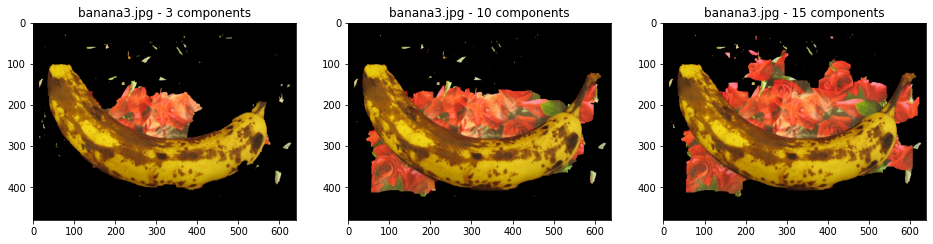

In [20]:
tune_parameters(_mixture_components, 'components')

## Inference

It can be observed that increasing the number of components deteriorates the quality of the output. It can be observed that more amount of noise / background pixels can be observed when components count increase from 3 to 15. This is due to the inaccurate learning of GMM parameters, due to the incorrect number of components which are passed as a parameter for training. 

Trying to incorporate more components tells us how the Mixture Model tries to view similar pixels also as belonging to different partitions, affecting output quality.

For GMM
Iteration-1, Mincut value = 3281813.5362746366
Iteration-2, Mincut value = 3235211.151328437
Iteration-3, Mincut value = 3212828.7943438264
Time taken overall = 291.33971643447876 secs
Accuracy = 0.865419921875, Jaccard sim = 0.635997851715546, Dice sim = 0.7775045071711111
------------------------------------------------------------------------------------------------------------------------

For Bayesian Gaussian


/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Iteration-1, Mincut value = 3275636.0808813632


/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Iteration-2, Mincut value = 3230772.4997114944


/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/gokulvamsit/miniconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Iteration-3, Mincut value = 3207844.275196327
Time taken overall = 470.177946805954 secs
Accuracy = 0.8661067708333333, Jaccard sim = 0.6376131027373726, Dice sim = 0.7787103091341446
------------------------------------------------------------------------------------------------------------------------



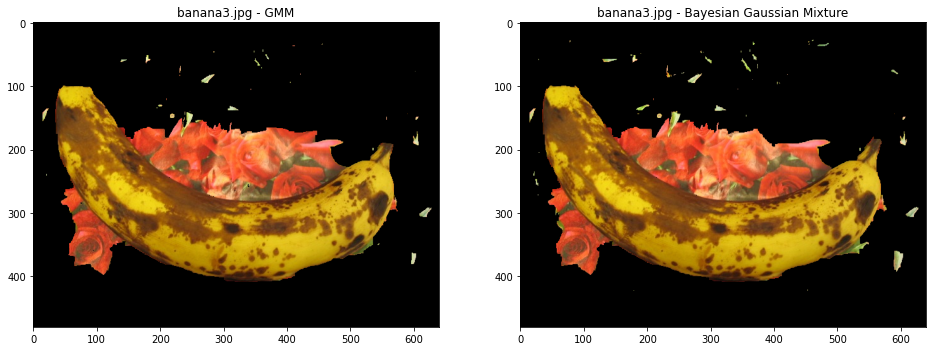

In [22]:
tune_parameters(is_bayesian, 'mixture')

## Inference

On altering the probabilistic models used in grabcut (replacement for GMM, a Bayesian Gaussian Mixture idea was used), there is no noticeable difference in performance, which suggests that in this case, the choice of model (typically mixture model) doesn't play a very big role.

For 4 neighbours:
Iteration-1, Mincut value = 3281614.8426905107
Iteration-2, Mincut value = 3226284.9660843126
Iteration-3, Mincut value = 3202133.6085111904
Time taken overall = 374.3369126319885 secs
Accuracy = 0.8692057291666667, Jaccard sim = 0.6409807355516638, Dice sim = 0.7812166488794023
------------------------------------------------------------------------------------------------------------------------

For 8 neighbours:
Iteration-1, Mincut value = 3281964.9041763158
Iteration-2, Mincut value = 3226314.7734883856
Iteration-3, Mincut value = 3202177.746344845
Time taken overall = 363.5577235221863 secs
Accuracy = 0.8692317708333334, Jaccard sim = 0.6410265575293992, Dice sim = 0.7812506806647644
------------------------------------------------------------------------------------------------------------------------



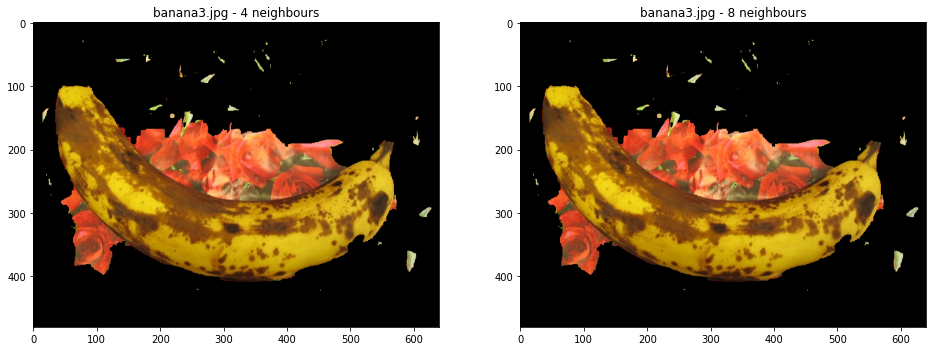

In [21]:
tune_parameters(_neighbours, 'neighbours')

## Inference

It can be seen that there is no noticable difference in performance on increasing the number of neighbours from 4 to 8. This drives home the point that the information captured by the 4 neighbours for a pixel is significant enough to draw inferences regarding its pairwise potential and consequently the labels.

For 20 gamma:
Iteration-1, Mincut value = 3281837.879298887
Iteration-2, Mincut value = 3235231.851598813
Iteration-3, Mincut value = 3208875.902728065
Time taken overall = 361.0185239315033 secs
Accuracy = 0.8709993489583333, Jaccard sim = 0.6479112248343017, Dice sim = 0.7863423891653503
------------------------------------------------------------------------------------------------------------------------

For 50 gamma:
Iteration-1, Mincut value = 3281839.620938758
Iteration-2, Mincut value = 3238849.22795878
Iteration-3, Mincut value = 3218763.630392131
Time taken overall = 351.94122195243835 secs
Accuracy = 0.835556640625, Jaccard sim = 0.5908858996266572, Dice sim = 0.7428388167439588
------------------------------------------------------------------------------------------------------------------------

For 100 gamma:
Iteration-1, Mincut value = 3285022.0381198837
Iteration-2, Mincut value = 3235445.535453364
Iteration-3, Mincut value = 3208476.3398723174
Time taken overall = 34

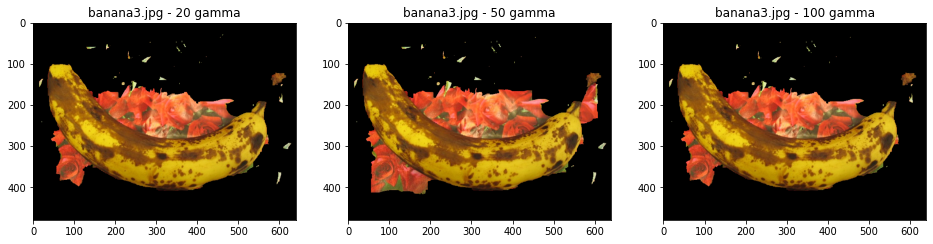

In [22]:
tune_parameters(_gamma, 'gamma')

## Inference

It can be seen that on either decreasing or increasing the value of gamma, there is an improvement in performance. This suggests that for the given data, such kinds of values for gamma are more suitable, rather than the value '50' suggested in the paper. We can clearly see relatively accurate clipping of background for both higher and lower values of gamma, rather than moderate values.

Although, we cannot draw concrete conclusions in this aspect as the difference in performance is not significantly larger.

For auto beta:
Iteration-1, Mincut value = 3281728.9769741744
Iteration-2, Mincut value = 3235264.9842755706
Iteration-3, Mincut value = 3213216.5749584236
Time taken overall = 349.5156798362732 secs
Accuracy = 0.8469075520833333, Jaccard sim = 0.605671356463703, Dice sim = 0.7544150974924544
------------------------------------------------------------------------------------------------------------------------

For 0.2 beta:
Iteration-1, Mincut value = 3284693.8090613754
Iteration-2, Mincut value = 3235522.023538548
Iteration-3, Mincut value = 3212838.9587827027
Time taken overall = 359.17147755622864 secs
Accuracy = 0.865244140625, Jaccard sim = 0.6356956165902511, Dice sim = 0.7772786209642275
------------------------------------------------------------------------------------------------------------------------

For 0.8 beta:
Iteration-1, Mincut value = 3281926.3617149848
Iteration-2, Mincut value = 3235149.855976984
Iteration-3, Mincut value = 3208725.441062807
Time taken overall 

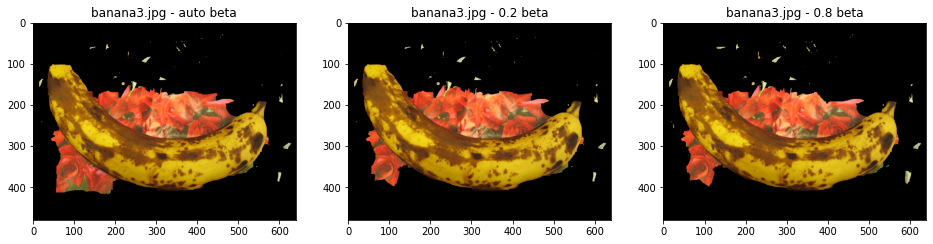

In [23]:
tune_parameters(_beta, 'beta')

## Inference

Similar to gamma, the smoothness parameter beta also seems to achieve better performance either decreasing or increasing its value. It has been experimented such that instead of average squared distance between pixel intensities being utilized in the denominator, a different value such that a fixed percentage of the intensity differences between pairs of pixels is above / below it (such as across all pairwise intensity distances, 20% are below this threshold etc.). 

For the given data, such kinds of values for beta seem to be more suitable, rather than the approach suggested in the paper. We can clearly see relatively accurate clipping of background for both higher and lower values of gamma, rather than moderate values.

Although, we cannot draw concrete conclusions in this aspect as the difference in performance is not significantly larger.